## Calcaulte GDD to dynamically estimate planting date
- Main tasks:
- Data source:
- Main output:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from palettable.colorbrewer.sequential import RdPu_8
from funcs import calc_gdd

### Step 1. Read in temperature data taylored for GDD calculation
- Code here is a bit of a redundant process, but I'm reading in only temperature data, <br/>
and only data starting from Feburary and ending by July to calculate GDD.
- Reason for this redundancy is because the initial read in of weather files started from March. <br/>
I didn't want to push that earlier to Feburary since that would likely reduce the number of available site-years.
- Code mostly taken from weafile_read.ipynb and only slightly modified.

#### 1961-1990

In [ ]:
%%time 
warnings.filterwarnings(action='ignore')

# timing related settings
years = np.arange(1961, 1991) # timeframe in which we have weather data
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '02-01-', '6-30-' # setting a pretty borad range for growing season

# setting up np.read_fwf arguments
colnames = ['time', 'temp', 'temp_quality']
colspecs = [(15,25), (87,92), (92,93)]

# empty dataframes to store data from all site-years
df_temp_all = pd.DataFrame()

# reading in all weather data and storing as dataframe
for year in years:
    print(year) # output to track code progress
    times = pd.date_range(season_start + str(year), season_end + str(year) + ' 23:00:00', freq='1H')
    fnames = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/*')
    
    # creating dataframes to store all site data for an individual year
    df_temp_sites = pd.DataFrame(index=times)
    
    for name in fnames:
        # WBAN site name 
        site_id = name.split('/')[-1].split('-')[-2]
        
        # read in individual files
        df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                         encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                         parse_dates=True, date_parser=dateparse)
    
        # remove duplicated hours, keeping only the first measurement per hour
        df = df[df.index.duplicated(keep='first') == False]
        
        # add in missing time values (corrects for leap years) and keeps only growing season
        df = df.reindex(times, fill_value=np.nan)
                    
        # filtering out weather data based on quality code (data manual p.26)
        # removing data with code 3 (Erroneous) or 7 (Erroneous, data originate from an NCEI data source)
        # - temp
        quality_temp = (df.temp_quality=='3') | (df.temp_quality=='7')
        rows_temp = df[quality_temp].index
        df.loc[rows_temp, 'temp'] = np.nan

        # replacing missing data with NaN
        df.temp = df.temp.replace({9999: np.nan})
        
        # converting units 
        df.temp = df.temp/10
        
        # combining weather data into individual dataframes
        df_temp = pd.DataFrame({site_id: df.temp}, index= times)
        df_temp_sites = pd.concat([df_temp_sites, df_temp], axis= 1, sort=True)

    # combining all site-years data together
    df_temp_all = pd.concat([df_temp_all, df_temp_sites], sort=True)

#df_temp_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/temp_6190_gdd.csv')

#### 1991-2010

In [ ]:
# reading in USAF site information - from solar radiation dataset
df_sites = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv')
df_sites.head()

# select only class 1 stations (see NSRDB manual p.7-8 for more details)
df_class1 = df_sites[(df_sites['CLASS'] == 1)]
sites_class1 = list(df_class1.USAF) # station list with class 1 quality

In [ ]:
%%time

# timing related settings
years = np.arange(1991, 2011) # timeframe in which we have weather data
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '02-01-', '6-30-' # setting a pretty borad range for growing season

# setting up np.read_fwf arguments
colnames = ['time', 'temp', 'temp_quality']
colspecs = [(15,25), (87,92), (92,93)]

# empty dataframes to store data from all site-years
df_temp_all = pd.DataFrame()

# reading in all weather data and storing as dataframe
for year in years:
    print(year) # output to track code progress
    times = pd.date_range(season_start + str(year), season_end + str(year) + ' 23:00:00', freq='1H')
    
    # creating dataframes to store all site data for an individual year
    df_temp_sites = pd.DataFrame(index=times)
    
    for site in sites_class1:
        # selecting for file associated with specified site
        file = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/' + str(site) + '-*')
        
        if len(file) == 0: # when specified site does not exist for current year
            continue # skip the following code and move on to the next site in the for loop
        elif len(file) == 1:
            name = file[0]
        else: # when specified USAF site has more than one WBAN ID, resulting in more than one unique site
            print('choosing from multiple files: ', file)
            name = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/' + str(site) + '-99999-*')[0]
            # for cases when a USAF station ID is linked to two WBAN IDs, select the one in which WBAN is listed as 99999
            
        # reading in raw weather data as fixed-width data format
        df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                         encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                         parse_dates=True, date_parser=dateparse)
        # remove duplicated hours, keeping only the first measurement per hour
        df = df[df.index.duplicated(keep='first') == False]

        # add in missing time values (corrects for leap years) and keeps only growing season
        df = df.reindex(times, fill_value=np.nan)
                
        # filtering out weather data based on quality code (data manual p.26)
        # removing data with code 3 (Erroneous) or 7 (Erroneous, data originate from an NCEI data source)
        # - temp
        quality_temp = (df.temp_quality=='3') | (df.temp_quality=='7')
        rows_temp = df[quality_temp].index
        df.loc[rows_temp, 'temp'] = np.nan

        # replacing missing values with NANs                    
        df.temp = df.temp.replace({9999: np.nan})

        # converting units 
        df.temp = df.temp/10

        # combining weather data into individual dataframes
        df_temp = pd.DataFrame({site: df.temp}, index= times)
        df_temp_sites = pd.concat([df_temp_sites, df_temp], axis= 1, sort=True)

    # combining all site-years data together
    df_temp_all = pd.concat([df_temp_all, df_temp_sites], sort=True)

#df_temp_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/temp_9110_gdd.csv')

#### Merge two temp datasets

- Read in and stitch together pre-processed temperature info

In [2]:
# read in weather data 1961-1990
df_temp_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_6190_gdd.csv', index_col=0)
# convert station ID header from WBAN to USAF (in order to make continuous with 1991-2010)
df_stations = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/stations_wban_usaf.csv', header=None, dtype='str')
df_stations.columns = ['WBAN', 'USAF']
sites_wban = list(df_temp_6190.columns)
sites_usaf = df_stations[df_stations['WBAN'].isin(sites_wban)]['USAF']

# assign new USAF headers
df_temp_6190.columns = sites_usaf; df_temp_6190 = df_temp_6190.sort_index(axis=1)
print('1961-1990: ', df_temp_6190.shape)

# read in weather data 1991-2010
df_temp_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_9110_gdd.csv', index_col=0)
print('1991-2010: ', df_temp_9110.shape)

# stitch two time periods together
df_temp = pd.concat([df_temp_6190, df_temp_9110], axis=0, join='outer'); df_temp = df_temp.sort_index(axis=1)
print('1961-2010: ', df_temp.shape)

1961-1990:  (108168, 237)
1991-2010:  (72120, 241)
1961-2010:  (180288, 274)


### Step 2. Select valid site-years (based on growing season)
- Read in pre-processed site-year info

In [3]:
# filter and select site-years based on planting area & percent irrigated
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', 
                         index_col=0, dtype={'site':str})
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)] 

# how many site-years left?
df_siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv', dtype='str', usecols=[1,2])
siteyears_filtered = df_siteyears[df_siteyears.site.isin(df_filtered.site)]
print('prior:', df_siteyears.shape[0])
print('filtered:', siteyears_filtered.shape[0]) 

prior: 4225
filtered: 2603


### Step 3. Estimate GDD-based planting date
- Heat accumulation starting Feburary 1st

In [4]:
# estimate gdd-based planting date
pdates = []
doys = []

for i in np.arange(siteyears_filtered.shape[0]):
    site = siteyears_filtered.iloc[i,:].site
    year = siteyears_filtered.iloc[i,:].year
    df_temp_slice = pd.DataFrame(df_temp[str(year)+'-02-01':str(year)+'-06-30'][str(site)]).interpolate()
    temps = list(df_temp_slice.iloc[:,0])
    loc = calc_gdd(temps)
    pdate = list(df_temp_slice.index)[loc][:10]
    pdate = pd.to_datetime(pdate)
    doy = pdate.dayofyear
    pdates.append(pdate)
    doys.append(doy)
    
# create new dataframe to store planting date info
df_pdate = siteyears_filtered.copy()
df_pdate['doy'] = doys
df_pdate['pdate'] = pdates
df_pdate.head()

,site,year,doy,pdate
206,722070,1961,53,1961-02-22
207,722070,1962,51,1962-02-20
208,722070,1965,54,1965-02-23
209,722070,1970,61,1970-03-02
210,722070,1971,55,1971-02-24


### Step 4. Visualize planting dates

Text(0.5, 1.0, 'Planting dates later than March 1st')

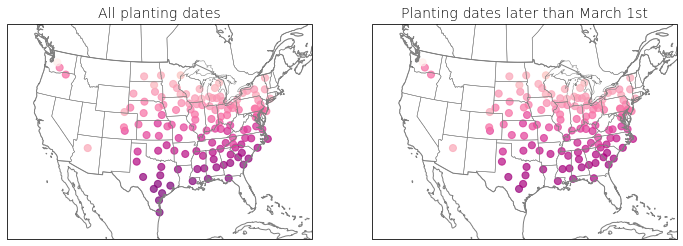

In [5]:
# select sites with planting dates that start later than March 1st
df_latep = df_filtered[df_filtered.site.isin(set(df_pdate[df_pdate.doy > 60].site))]

# visualization
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123,-72,19,53])
ax1.scatter(df_filtered.lon, df_filtered.lat, s=50, transform=ccrs.PlateCarree(),
            c=list(df_pdate.groupby('site').mean().doy), 
            vmin=50, vmax=180, cmap=RdPu_8.mpl_colormap.reversed(), alpha=0.7)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('All planting dates', fontweight='light', fontsize=14)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                      central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
ax2.scatter(df_latep.lon, df_latep.lat, s=50, transform=ccrs.PlateCarree(),
            c=list(df_pdate[df_pdate.doy>60].groupby('site').mean().doy),
            vmin=50, vmax=180, cmap=RdPu_8.mpl_colormap.reversed(), alpha=0.7)
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Planting dates later than March 1st', fontweight='light', fontsize=14)

### Step 4. Identify site-years that have planting dates starting from March 1st
- Main output: siteyears_filtered.csv

In [6]:
df_siteyears_filtered = df_pdate[df_pdate.doy>60]
df_siteyears_filtered.reset_index(drop=True, inplace=True)
df_siteyears_filtered.head()
#df_siteyears_filtered.to_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_filtered.csv')